\begin{aligned}&\frac{dx}{dt}=2x+3y\\&\frac{dy}{dt}=-4y.\end{aligned}
$$x(0)=0 \\y(0)=1$$


$$\begin{aligned}&x(t)=\frac{1}{2}e^{2t}-\frac{1}{2}e^{-4t}\\&y(t)=e^{-4t}.\end{aligned}$$

### 原始代码  
BsplineKANLayer

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from deepkan import SplineLinearLayer
from BKAN import SplineLinearLayer
import random
from torch import autograd
from tqdm import tqdm
import os
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import nodepy.linear_multistep_method as lm
import torch.nn as nn
import torch.optim as optim


# Define the custom KAN layer
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 num_knots=10, spline_order=3, 
                 noise_scale=0.1, base_scale=1.0, 
                 spline_scale=1.0, activation=nn.SiLU, 
                 grid_epsilon=0.02, grid_range=[0, 11000]):
        super(KANLayer, self).__init__()
        self.linear = SplineLinearLayer(in_features, out_features, num_knots, 
                                        spline_order, noise_scale, base_scale, 
                                        spline_scale, activation, grid_epsilon, grid_range)

    def forward(self, x):
        return self.linear(x)

# Define the combined model
class KANModel(nn.Module):
    def __init__(self):
        super(KANModel, self).__init__()
        self.kan_layer1 = KANLayer(2 ,5)    
        # self.ln1 = nn.Tanh()
        # self.ln1 = nn.Sigmoid()
        self.kan_layer2 = KANLayer(5, 2)  

    def forward(self, x):
        x = x.view(-1, 2)  # Flatten the input tensor
        x = self.kan_layer1(x)
        x = self.kan_layer2(x)
        return x
    
torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数

Epoch 1/6000, Train_loss:  2.4529790976167312e+09,  Test_loss:  2.2420026907034131e+02
Epoch 1001/6000, Train_loss:  2.3287445726684949e-07,  Test_loss:  1.8769592660163266e-02
Epoch 2001/6000, Train_loss:  4.2163295560598390e-08,  Test_loss:  8.8509070836673698e-03
Epoch 3001/6000, Train_loss:  1.2425562209642417e-08,  Test_loss:  7.9536799763791702e-03
Epoch 4001/6000, Train_loss:  5.7015888595986204e-09,  Test_loss:  6.5099107076459556e-03
Epoch 5001/6000, Train_loss:  7.3194154266073497e+05,  Test_loss:  2.0020045579457271e-01


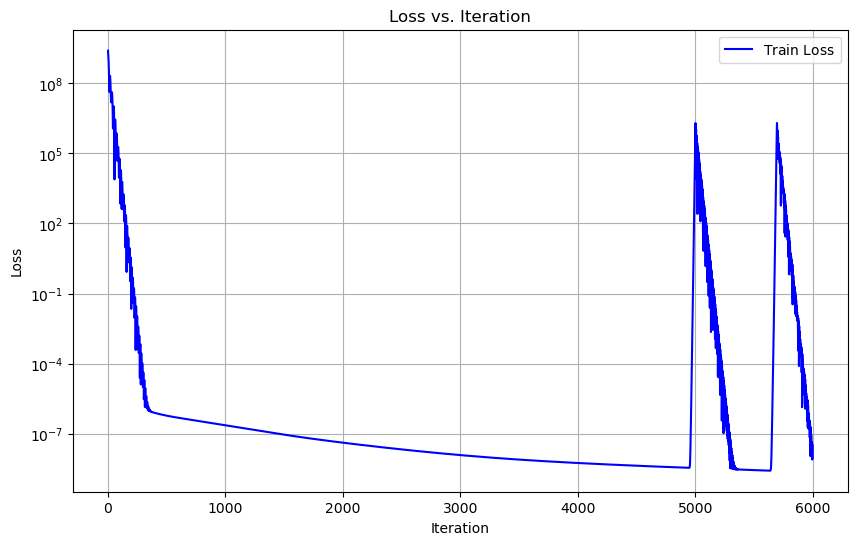

In [2]:
# define solution
sol_fun_1 = lambda x:  2 * x[:,[0]] + 3 * x[:,[1]] 
sol_fun_2 = lambda x:   - 4 * x[:,[1]] 

# source_fun_1 = lambda t: 0.5*torch.exp(2*t) - 0.5*torch.exp(-4*t)
# source_fun_2 = lambda t: torch.exp(-4*t) 

# source_fun_1 = lambda t: torch.exp(2*t)
# source_fun_2 = lambda t: torch.tensor(0*t)

y0 = np.array([0,1])     # 方程初始值

source_fun_1 = lambda t: (torch.tensor(y0[0])+ torch.tensor(y0[1]/2))*torch.exp(2*t) - (torch.tensor(y0[1]/2)) *torch.exp(-4*t)
source_fun_2 = lambda t: (torch.tensor(y0[1])) *torch.exp(-4*t)


torch.manual_seed(0)
# 超参数
n_steps = 10000          # 样本取点数     
steps = 6000             # 迭代次数
log = 1                  # 迭代序号
M = 1                  # 多步法的步数
# y0 = np.array([0,1])     # 方程初始值
# y0 = np.array([1,0])     # 方程初始值
t0 = torch.from_numpy(np.array([0])).unsqueeze(0)  # 初始时间
t_np = np.linspace(0, 10, num=n_steps)
dt = t_np[M] - t_np[0]   # 步长


def f(x,t): # x is 2 x 1
    A = np.array([[2,3], [0,-4]]) # 2 x 2
    f = np.matmul(A,x[:,None]) # 2 x 1
    return f.flatten()

# # 计算出微分方程的数值解，它使用 lsoda 方法进行数值积分，lsoda 方法使用了 Gear 公式的变步长、变阶数实现。它是一种隐式的多步法
# y_np = odeint(f, y0, t_np) 

# 计算微分方程的真实解
y_np1 = source_fun_1(torch.from_numpy(t_np))
y_np2= source_fun_2(torch.from_numpy(t_np))
y_np = torch.stack([y_np1, y_np2], axis=1).numpy()
# mu = y_np.mean() 
# noise = 0.05 * abs(mu)
noise = 0

y_train = y_np[0::M,:]
y_train = y_train + noise*np.random.randn(y_train.shape[0], y_train.shape[1])

model = KANModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05,betas=(0.9, 0.999),  eps=1e-32)

def net_Y(alpha,beta,T,y_train_new):
    Y = alpha[0] * T[:, M:, :] + dt * beta[0] * model(y_train_new[M:, :]).unsqueeze(0)
    for m in range(1, M + 1):
        Y = Y + alpha[m] * T[:, M-m:-m, :] + dt * beta[m] * model(y_train_new[M-m:-m, :]).unsqueeze(0) # S x (N-M+1) x D
    return Y


# 用于存储每次迭代的损失值
Train_loss_list = []
Test_loss_list = []
iteration_list = []

for epoch in range(steps):
    model.train()
    scheme = 'AM'
        # Load weights
    switch = {'AM': lm.Adams_Moulton,
                'AB': lm.Adams_Bashforth,
                'BDF': lm.backward_difference_formula}
    method = switch[scheme](M)

    # 将 method.alpha 和 method.beta 转换为浮点数数组
    alpha = torch.tensor(-np.array(method.alpha[::-1], dtype=np.float32))
    beta = torch.tensor(np.array(method.beta[::-1], dtype=np.float32))

    y_train_new  = torch.tensor(y_train)
    T = y_train_new.unsqueeze(0)
    optimizer.zero_grad()
    Y_pred = net_Y(alpha,beta,T,y_train_new)
    loss = torch.mean((Y_pred)**2)
    # loss = criterion(Y_pred, torch.zeros_like(Y_pred))
    loss.backward()
    optimizer.step()

    test_steps = 1000
    # test_np = np.random.uniform(0, 2, test_steps)
    test_np = np.linspace(1, 2, num=test_steps)
    y_test_np1 = source_fun_1(torch.from_numpy(test_np))
    y_test_np2 = source_fun_2(torch.from_numpy(test_np))
    y_test_np = torch.stack([y_test_np1, y_test_np2], axis=1)
    # y_test_new = torch.cat((y_test_np1, y_test_np2), dim=0)
    f_test_1 =sol_fun_1(y_test_np)
    f_test_2 =sol_fun_2(y_test_np)
    f_test = torch.cat((f_test_1, f_test_2), dim=1).detach()
    f_nn= model(y_test_np).detach()
    Test_loss =  torch.mean((f_test - f_nn)**2)


    # 存储损失值和迭代次数
    Train_loss_list.append(loss.cpu().detach().numpy())
    Test_loss_list.append(Test_loss.cpu().detach().numpy())
    iteration_list.append(epoch)



    if epoch % 1000 == 0:
        print(f'Epoch {epoch+1}/{steps}, Train_loss: {loss.item(): .16e},  Test_loss: {Test_loss.item(): .16e}')
            # print(f'Epoch {epoch+1}/{steps}, loss: {loss.item(): .16e}')

plt.figure(figsize=(10, 6))
plt.plot(iteration_list, Train_loss_list, label=r'$\mathrm{Train\ Loss}$', color='b')
plt.yscale('log')
# plt.ylim(10e-15, 10e1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
test_steps = n_steps
test_np = np.linspace(0, 10, test_steps)
test_np_new = torch.linspace(0, 10, test_steps)
# t_span = (0, 2)

def predict_f(y_star):
    y_star_tensor = torch.tensor(y_star)
    with torch.no_grad():
        F_star = model(y_star_tensor)
    return F_star.numpy()


def learned_f(x,t):
    f = predict_f(x[None,:])
    return f.flatten()

# def learned_f(t,x):
#     f = predict_f(x[None,:])
#     return f.flatten()

# learned_X_star = solve_ivp(learned_f, t_span, y0, method='BDF', t_eval=test_np)

learned_X_star = odeint(learned_f, y0, test_np)    

source_fun_1(test_np_new).type

lossx1 = np.max(learned_X_star[:,0]-source_fun_1(test_np_new).numpy())
lossx2 = np.max(learned_X_star[:,1]-source_fun_2(test_np_new).numpy())
print('x1_loss: {lossx1: .16e}, x2_loss: {lossx2: .16e}'.format(lossx1=lossx1, lossx2=lossx2))

x1_loss:  2.3399536420530081e+06, x2_loss:  2.6643314934920437e-02


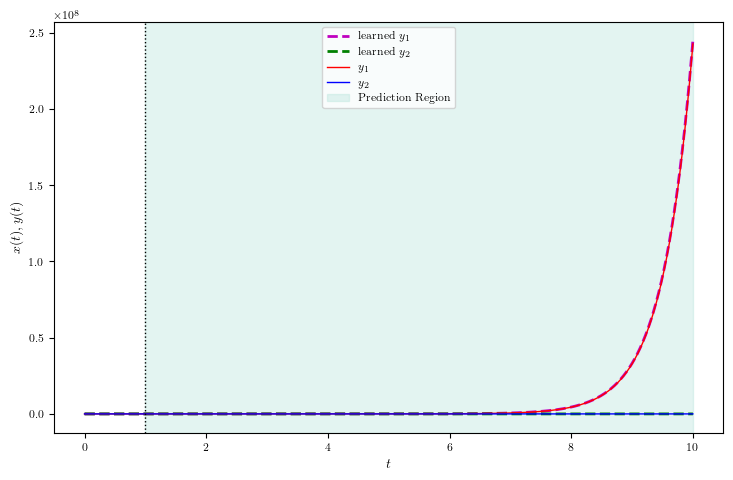

In [4]:
####### Plotting ################## 
#source_fun_1 = lambda t: 0.5*torch.exp(2*t) - 0.5*torch.exp(-4*t)
#source_fun_2 = lambda t: torch.exp(-4*t) semilogy

# 使用plotting.py中的默认配置
from plotting import newfig, savefig
import matplotlib.pyplot as plt

fig, ax = newfig(1.6)
ax.plot(test_np, learned_X_star[:,0], 'm--', label='learned $y_1$',linewidth=2)
ax.plot(test_np, learned_X_star[:,1], 'g--', label='learned $y_2$',linewidth=2)
ax.plot(test_np, source_fun_1(test_np_new), label='$y_1$', color='r',linewidth=1)
ax.plot(test_np, source_fun_2(test_np_new), label='$y_2$', color='b',linewidth=1)

# 在x=1处画虚线
ax.axvline(x=1, color='k', linestyle=':', linewidth=1)

# 在x=1右边添加阴影区域
ax.axvspan(1, max(test_np), alpha=0.3, color='#A4DDD3', label='Prediction Region')

# #FA98C7  #A4DDD3

# 添加图表标题和坐标轴标签
ax.set_xlabel('$t$')
ax.set_ylabel('$x(t), y(t)$')
ax.legend(loc='upper center')

# 使用plotting.py的保存函数（可选）
plt.savefig('x_xnn1_101.png', format='png', dpi=600)
# savefig('./figures/odes_result')
plt.show()

In [5]:
# ####### Plotting ################## 
# import matplotlib.gridspec as gridspec
# from plotting import newfig, savefig

# fig, ax = newfig(1.0, 0.9)
# ax.axis('off')

# gs0 = gridspec.GridSpec(1, 2)
# gs0.update(top=0.85, bottom=0.25, left=0.1, right=0.95, wspace=0.3)

# ax = plt.subplot(gs0[:, 0:1])
# ax.plot(test_np,source_fun_1(test_np_new),'r',label='$x$')
# ax.plot(test_np,source_fun_2(test_np_new),'b',label='$y$')
# ax.plot(test_np,learned_X_star[:,0],'k--',label='learned model')
# ax.plot(test_np,learned_X_star[:,1],'k--')    
# ax.set_xlabel('$t$')
# ax.set_ylabel('$x, y$')
# ax.legend(loc='upper center', bbox_to_anchor=(0.9, -0.25), ncol=3, frameon=False)
# ax.set_title('Trajectories', fontsize = 10)

# ax = plt.subplot(gs0[:, 1:2])
# ax.plot(source_fun_1(test_np_new),source_fun_2(test_np_new), 'm', label='$(x,y)$')
# ax.plot(learned_X_star[:,0],learned_X_star[:,1],'k--')
# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.legend(loc='upper center', bbox_to_anchor=(0.4, -0.25), ncol=1, frameon=False)
# ax.set_title('Phase Portrait', fontsize = 10)


# # plt.savefig('x_xnn1.png', format='png', dpi=600)
# # savefig('./figures/Cubic2D')

In [6]:
# train_input1 = y_train_new
# train_label1 = model(y_train_new)

# # 将两个数据保存到一个.npy文件中
# train_data = {
#     'train_input': train_input1.detach().cpu().numpy(),
#     'train_label': train_label1.detach().cpu().numpy()
# }

# # 使用 numpy 的 savez 函数保存多个数组到一个文件
# np.savez('train_data11.npz', **train_data)


In [7]:
# # 读取保存的数据
# import numpy as np
# import torch

# # 读取 .npz 文件
# loaded_data = np.load('train_data11.npz')

# # 查看文件中包含的数据键名
# print("文件中包含的数据键名:", list(loaded_data.keys()))

# # 提取数据
# train_input_loaded = loaded_data['train_input']
# train_label_loaded = loaded_data['train_label']

# print("train_input 形状:", train_input_loaded.shape)
# print("train_label 形状:", train_label_loaded.shape)

# # 如果需要转换为 PyTorch 张量
# train_input_tensor = torch.from_numpy(train_input_loaded)
# train_label_tensor = torch.from_numpy(train_label_loaded)

# print("已转换为 PyTorch 张量:")
# print("train_input_tensor 形状:", train_input_tensor.shape)
# print("train_label_tensor 形状:", train_label_tensor.shape)

# # 查看部分数据
# print("\ntrain_input 前5行:")
# print(train_input_loaded[:5])
# print("\ntrain_label 前5行:")
# print(train_label_loaded[:5])

In [8]:
# def create_dataset(f, n_var=2, ranges=[0,1],train_num=2000,test_num=1000, device='cpu',seed=0):

#     np.random.seed(seed)
#     torch.manual_seed(seed)

#     if len(np.array(ranges).shape) == 1:
#         ranges = np.array(ranges * n_var).reshape(n_var,2)
#     else:
#         ranges = np.array(ranges)
        
#     train_input = torch.zeros(train_num, n_var)
#     test_input = torch.zeros(test_num, n_var)
#     for i in range(n_var):
#         train_input[:,i] = torch.rand(train_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
#         test_input[:,i] = torch.rand(test_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        
#     # 计算标签
#     noise_scale = 0
#     train_label_clean = f(train_input)
#     # 生成与f(train_input)维度相同的随机噪声
#     train_label = train_label_clean + noise_scale * torch.randn(train_label_clean.shape, device=device)
#     test_label = f(test_input)

#     dataset = {}
#     dataset['train_input'] = train_input.to(device)
#     dataset['test_input'] = test_input.to(device)
#     dataset['train_label'] = train_label.to(device)
#     dataset['test_label'] = test_label.to(device)

#     return dataset

In [9]:
# dataset = create_dataset(model, ranges = [0,1], n_var=2)

In [10]:
# # 查看数据集信息
# print("数据集信息：")
# for key, value in dataset_v03.items():
#     print(f"- {key}: {value.shape}")
# print(f"\n数据类型: {type(dataset_v03['train_input'])}")
# print(f"设备: {dataset_v03['train_input'].device}")


In [11]:
# # 方法1：保存为单个 .npz 文件（推荐）
# np.savez('dataset_v03.npz', **{k: v.detach().cpu().numpy() for k, v in dataset_v03.items()})

# print("数据集已保存为 dataset_v03.npz 文件")
# print("包含以下数据：")
# for key, value in dataset_v03.items():
#     print(f"- {key}: {value.shape}")

# # 方法2：使用 pickle 保存整个字典结构（备选）
# import pickle

# # 将torch tensor转换为numpy保存（修复梯度问题）
# dataset_numpy = {k: v.detach().cpu().numpy() for k, v in dataset_v03.items()}
# with open('dataset_v03.pkl', 'wb') as f:
#     pickle.dump(dataset_numpy, f)

# print("\n同时也保存了 dataset_v03.pkl 文件（使用pickle格式）")

In [12]:
# # 演示如何在下一个程序中加载完整的数据集

# print("在下一个程序中，您可以使用以下代码加载完整的数据集：")
# print("\n========== 方法1：加载 .npz 文件（推荐） ==========")
# print("import numpy as np")
# print("import torch")
# print("")
# print("# 加载 .npz 文件")
# print("data = np.load('dataset.npz')")
# print("")
# print("# 重建数据集字典（转换为torch张量）")
# print("dataset = {")
# print("    'train_input': torch.from_numpy(data['train_input']),")
# print("    'test_input': torch.from_numpy(data['test_input']),")
# print("    'train_label': torch.from_numpy(data['train_label']),")
# print("    'test_label': torch.from_numpy(data['test_label'])")
# print("}")

# print("\n========== 方法2：加载 .pkl 文件 ==========")
# print("import pickle")
# print("import torch")
# print("")
# print("# 加载 pickle 文件")
# print("with open('dataset.pkl', 'rb') as f:")
# print("    dataset_numpy = pickle.load(f)")
# print("")
# print("# 转换为torch张量")
# print("dataset = {k: torch.from_numpy(v) for k, v in dataset_numpy.items()}")

# print("\n两种方法都能完整恢复您的数据集！")
